In [1]:
from tensorflow_similarity.utils import tf_cap_memory
tf_cap_memory()

In [2]:
import numpy as np
import random
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
try:
    import ipyplot
except:
    !pip install ipyplot
from ipyplot import plot_images
from plotly import express as ex
from pathlib import Path
from collections import defaultdict
from tabulate import tabulate

In [3]:
from tensorflow_similarity.samplers import SingleShotMemorySampler, MultiShotMemorySampler
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.models import SimilarityModel
from tensorflow_similarity.losses import PNLoss, TripletLoss, MultiSimilarityLoss


In [4]:
dset = '../tmp/quickdraw/'
x = []
y = []
class_names = {}
for idx, path in enumerate(Path(dset).glob('*.npy')):
    clname = str(path).split('_')[-1].replace('.npy', '')
    print("Loading %s" % clname)
    class_names[idx] = clname
    data = np.load(path)
    x.extend(data)
    y.extend([idx for _ in range(len(data))])
num_classes = idx + 1
x = np.array(x)
y = np.array(y)

# reshape and rescale
x = np.reshape(x, (len(y), 28, 28 , 1))
x = x / 255
print("num classes", num_classes)
print(x.shape, y.shape)

Loading airplane
Loading ant
Loading anvil
Loading apple
Loading banana
Loading basket
Loading basketball
Loading bed
Loading bee
Loading bicycle
Loading bridge
Loading broom
Loading flamingo
Loading star
Loading The Eiffel Tower
Loading tree
num classes 16
(2260301, 28, 28, 1) (2260301,)


# augmenter
the augmenter `num_augmentation` is indeed the value passed 
as SingleShotMemorySampler(num_augmentation)

In [5]:
batch_size = 64
examples_per_class = batch_size // num_classes
steps_per_epoch = 10000
sampler = MultiShotMemorySampler(x,y, 
                                 classes_per_batch=num_classes, 
                                 examples_per_class_per_batch=examples_per_class,
                                 steps_per_epoch=steps_per_epoch,
                                )


Batch size is 64 -> 16 class X 4 examples


indexing classes: 100%|██████████| 2260301/2260301 [00:00<00:00, 4170311.30it/s]


generate a batch used to check to vizualize the data and use as valdiation data to track progress


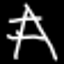
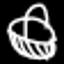
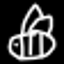
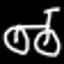
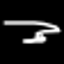
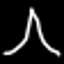
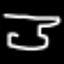
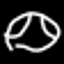
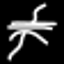
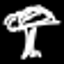
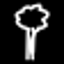
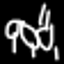


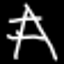
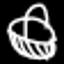
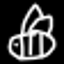
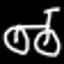
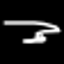
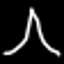
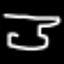
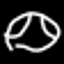
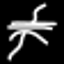
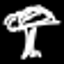
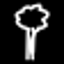
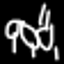

In [6]:

batch_x, batch_y = sampler.generate_batch(42)
p = tf.squeeze(batch_x, axis=-1)  # display requires to remove final dim
plot_images(p, batch_y, max_images=12, img_width=64)

In [7]:
def get_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = inputs
    x = layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='constant')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = MetricEmbedding(32)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)     

In [8]:
distance = 'cosine' #@param ["cosine", "L2", "L1"]{allow-input: false}
loss = MultiSimilarityLoss(distance=distance)

In [9]:
LR = 0.0001  #@param {type:"number"}
model = get_model()
model.compile(optimizer=Adam(LR), loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


In [10]:
EPOCHS = 10 #@param {type:"integer"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(batch_x, batch_y))

Epoch 1/10
10000/10000 [==============================] - 47s 4ms/step - loss: 1.6495 - val_loss: 1.0213
Warmup complete
Epoch 2/10
10000/10000 [==============================] - 44s 4ms/step - loss: 1.6228 - val_loss: 0.9894
Epoch 3/10
10000/10000 [==============================] - 45s 4ms/step - loss: 1.6057 - val_loss: 0.9687
Epoch 4/10
10000/10000 [==============================] - 45s 5ms/step - loss: 1.5944 - val_loss: 0.9685
Epoch 5/10
10000/10000 [==============================] - 44s 4ms/step - loss: 1.5844 - val_loss: 0.9714
Epoch 6/10
10000/10000 [==============================] - 45s 4ms/step - loss: 1.5778 - val_loss: 0.8931
Epoch 7/10
10000/10000 [==============================] - 45s 4ms/step - loss: 1.5695 - val_loss: 0.8948
Epoch 8/10
10000/10000 [==============================] - 44s 4ms/step - loss: 1.5625 - val_loss: 0.9494
Epoch 9/10
10000/10000 [==============================] - 44s 4ms/step - loss: 1.5556 - val_loss: 0.8864
Epoch 10/10
10000/10000 [==============

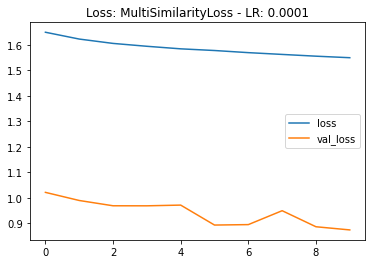

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(f'Loss: {loss.name} - LR: {LR}')
plt.show()

In [12]:
num_batches = 200
model.reset_index()  # reset index
for i in tqdm(range(num_batches), 'indexing'):
    ix, iy = sampler.generate_batch(i)
    model.index(ix, iy, verbose=0)
print("Index size", model.index_size())

indexing: 100%|██████████| 200/200 [00:17<00:00, 11.29it/s]

Index size 12800


In [13]:
test_batches = 500
distances = []
for i in tqdm(range(test_batches)):
    ix, iy = sampler.generate_batch(i)
    nns = model.lookup(ix, k=1, verbose=0)
    distances.extend([n[0].distance for n in nns])
best_cutpoint = np.quantile(distances, 0.001) 
avg_distance = np.average(distances)
std_distance = np.std(distances)
cutpoint = np.quantile(distances, 0.999)  # find the 0.001% of weird example 
print(avg_distance, std_distance, cutpoint, best_cutpoint)


100%|██████████| 500/500 [00:15<00:00, 33.11it/s]

0.005687185972929001 0.006602885446240381 0.046002325475215926 0.0


In [14]:
ex.histogram(x=distances, title="distances to index")

In [15]:
examples_to_check = 1000000
batch_size = 64  # its faster to do a bulk lookup

# randomize order to make sure we get all the classes in the n checked.
idxes = [i for i in range(len(x))] 
random.shuffle(idxes)
idxes = idxes[:examples_to_check]

pb = tqdm(total=examples_to_check)
anomalies = defaultdict(lambda: defaultdict(list))
best = defaultdict(lambda: defaultdict(list))
num_anomalies = 0
total = 0
for i in range(0, examples_to_check - batch_size, batch_size):
    batch_x = np.take(x, idxes[i: i + batch_size], axis=0)
    batch_y = np.take(y, idxes[i: i + batch_size], axis=0)
    
    nns = model.lookup(batch_x, verbose=0)
    for idx in range(batch_size):
        total += 1
        distance = nns[idx][0].distance
        cid = batch_y[idx]
        if  distance> cutpoint:
            # store the image

            anomalies[cid]['distances'].append(round(distance, 4))
            anomalies[cid]['images'].append(np.squeeze(batch_x[idx], axis=-1))
            num_anomalies += 1
            pb.set_postfix({"anomalies": num_anomalies, 
                            "anomaly rate": num_anomalies / total})
        
        if distance <= 0.001:
            best[cid]['distances'].append(round(distance, 4))
            best[cid]['images'].append(np.squeeze(batch_x[idx], axis=-1))
        pb.update()
pb.close()

100%|█████████▉| 999936/1000000 [08:13<00:00, 2025.67it/s, anomalies=858, anomaly rate=0.000859]


In [16]:
rows = []
for cid, data in anomalies.items():
    dists = data['distances']
    rows.append([class_names[cid], len(dists), np.max(dists), np.average(dists)])
print(tabulate(rows, headers=['class', 'anomalies', 'max dist', 'avg dist']))

class               anomalies    max dist    avg dist
----------------  -----------  ----------  ----------
banana                    214      0.1171   0.054057
bridge                     49      0.099    0.0534306
broom                      58      0.1369   0.0546155
ant                        50      0.09     0.053216
The Eiffel Tower           79      0.0903   0.0550152
star                       46      0.087    0.0527283
bee                        34      0.0895   0.0533441
flamingo                   57      0.089    0.0544684
basket                     33      0.0656   0.0516848
anvil                      41      0.0681   0.0520585
tree                       40      0.0978   0.0551475
bed                        20      0.0617   0.051545
airplane                   41      0.117    0.0525732
apple                      44      0.0828   0.0559045
basketball                 31      0.0719   0.0550581
bicycle                    21      0.0702   0.0526762



 banana
best



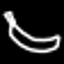
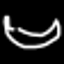
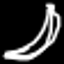
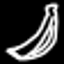
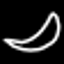
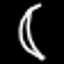
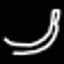
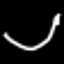
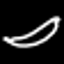
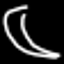
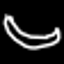
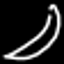
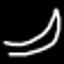
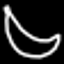
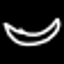
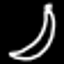


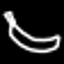
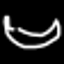
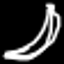
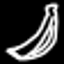
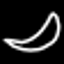
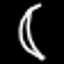
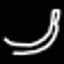
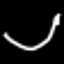
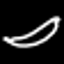
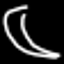
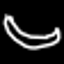
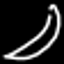
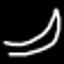
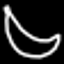
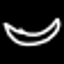
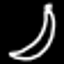

worst



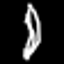
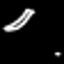
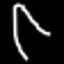
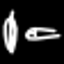
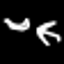
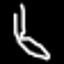
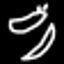
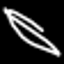
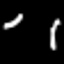
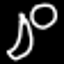
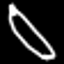
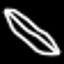
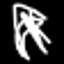
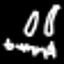
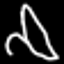
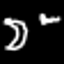


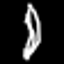
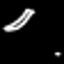
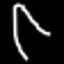
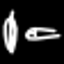
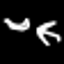
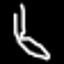
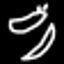
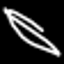
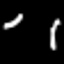
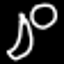
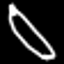
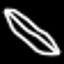
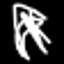
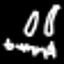
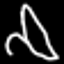
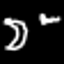


 bridge
best



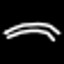
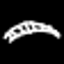
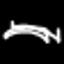
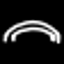
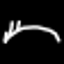
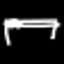
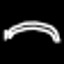
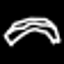
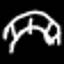
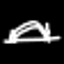
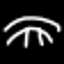
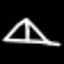
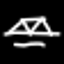
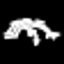
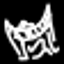
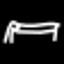


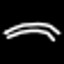
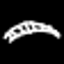
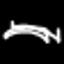
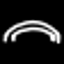
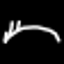
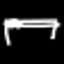
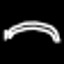
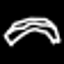
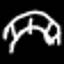
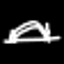
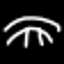
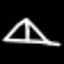
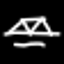
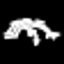
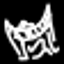
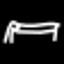

worst



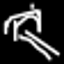
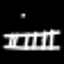
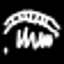
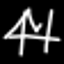
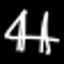
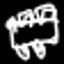
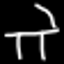
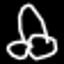
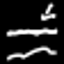
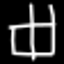
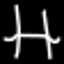
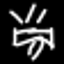
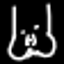
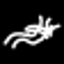
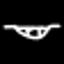
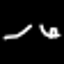


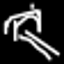
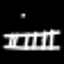
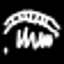
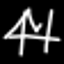
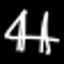
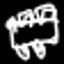
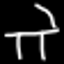
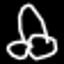
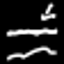
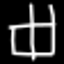
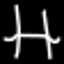
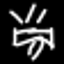
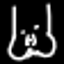
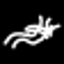
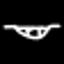
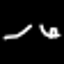


 broom
best



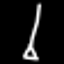
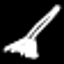
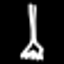
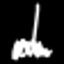
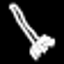
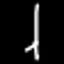
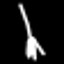
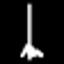
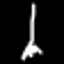
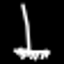
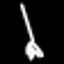
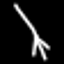
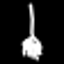
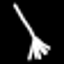
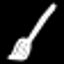
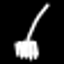


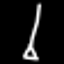
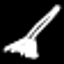
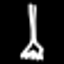
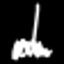
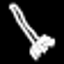
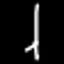
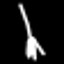
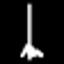
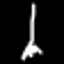
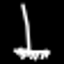
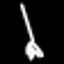
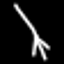
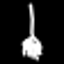
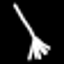
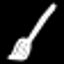
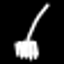

worst



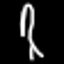
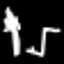
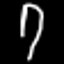
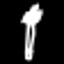
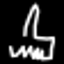
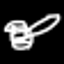
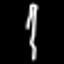
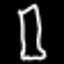
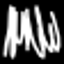
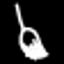
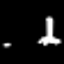
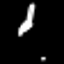
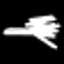
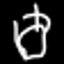
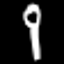
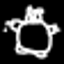


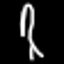
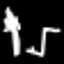
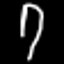
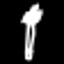
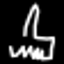
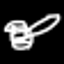
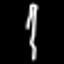
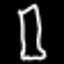
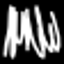
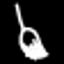
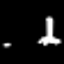
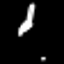
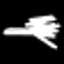
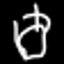
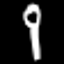
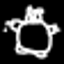


 ant
best



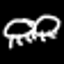
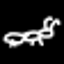
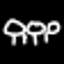
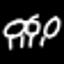
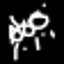
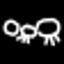
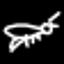
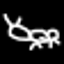
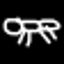
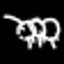
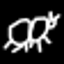
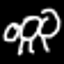
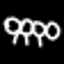
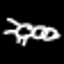
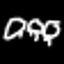
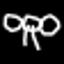


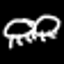
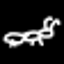
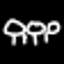
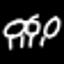
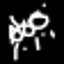
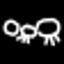
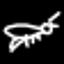
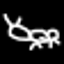
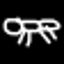
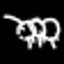
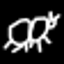
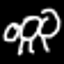
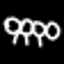
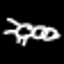
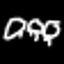
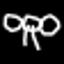

worst



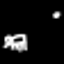
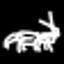
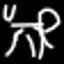
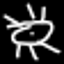
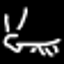
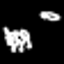
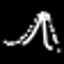
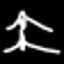
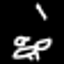
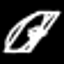
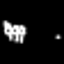
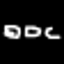
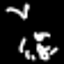
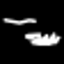
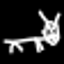
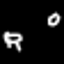


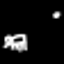
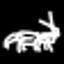
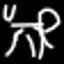
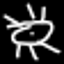
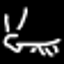
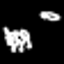
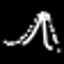
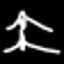
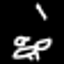
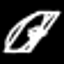
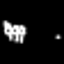
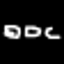
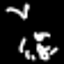
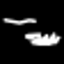
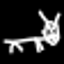
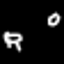


 The Eiffel Tower
best



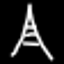
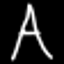
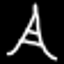
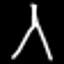
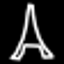
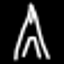
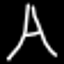
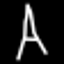
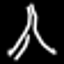
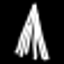
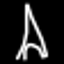
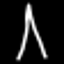
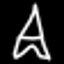
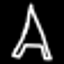
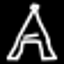
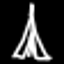


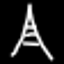
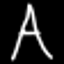
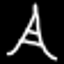
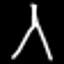
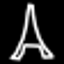
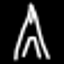
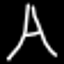
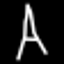
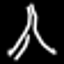
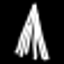
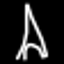
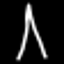
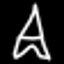
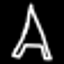
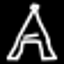
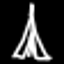

worst



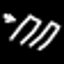
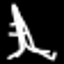
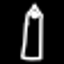
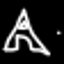
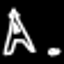
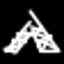
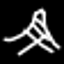
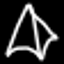
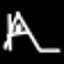
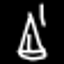
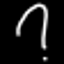
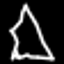
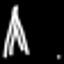
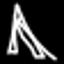
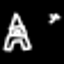
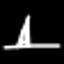


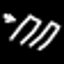
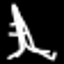
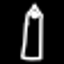
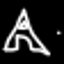
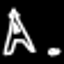
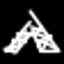
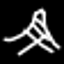
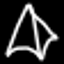
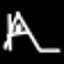
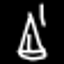
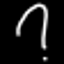
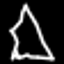
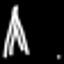
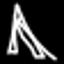
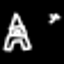
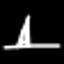


 star
best



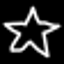
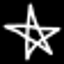
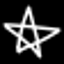
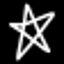
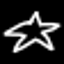
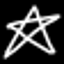
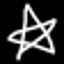
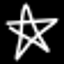
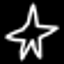
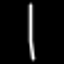
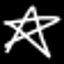
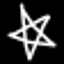
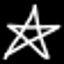
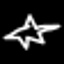
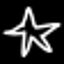
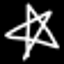


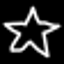
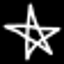
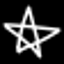
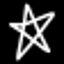
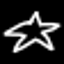
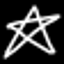
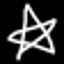
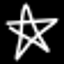
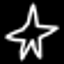
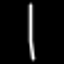
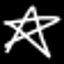
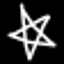
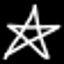
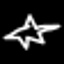
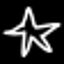
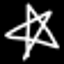

worst



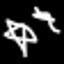
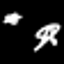
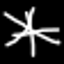
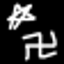
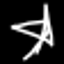
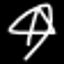
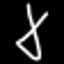
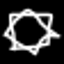
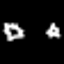
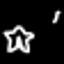
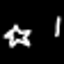
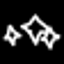
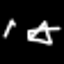
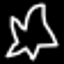
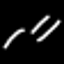
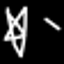


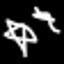
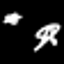
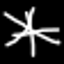
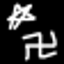
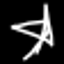
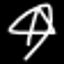
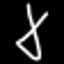
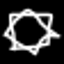
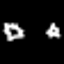
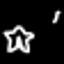
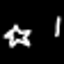
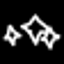
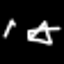
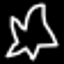
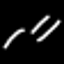
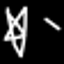


 bee
best



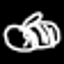
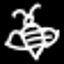
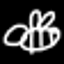
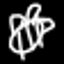
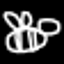
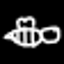
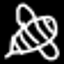
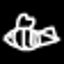
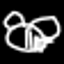
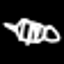
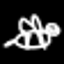
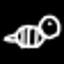
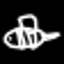
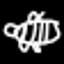
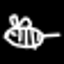
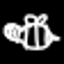


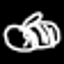
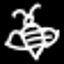
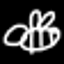
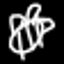
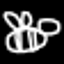
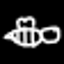
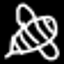
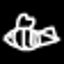
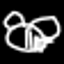
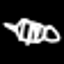
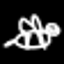
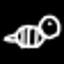
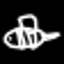
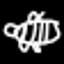
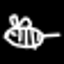
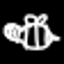

worst



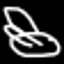
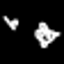
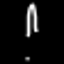
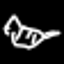
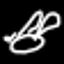
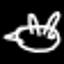
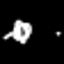
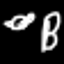
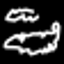
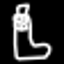
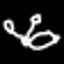
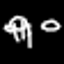
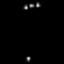
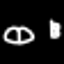
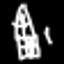
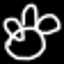


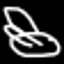
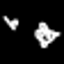
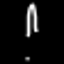
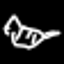
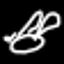
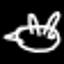
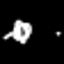
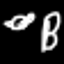
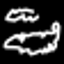
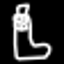
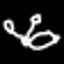
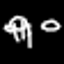
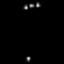
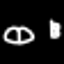
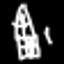
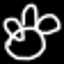


 flamingo
best



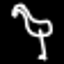
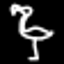
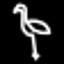
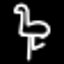
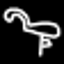
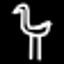
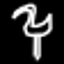
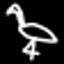
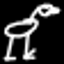
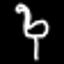
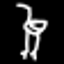
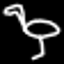
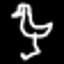
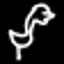
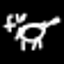
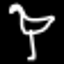


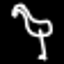
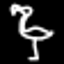
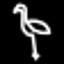
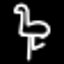
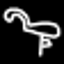
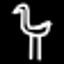
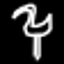
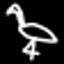
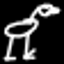
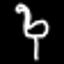
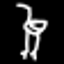
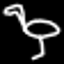
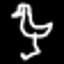
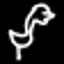
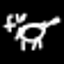
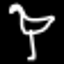

worst



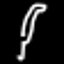
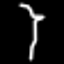
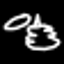
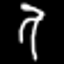
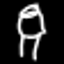
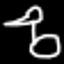
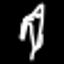
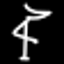
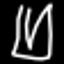
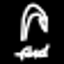
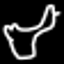
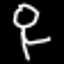
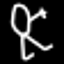
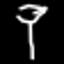
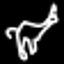
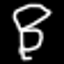


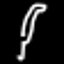
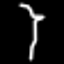
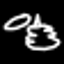
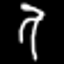
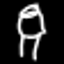
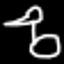
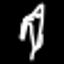
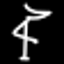
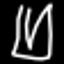
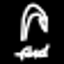
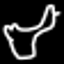
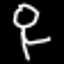
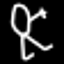
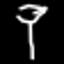
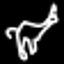
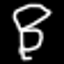


 basket
best



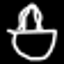
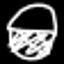
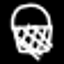
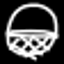
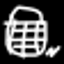
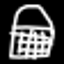
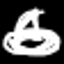
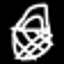
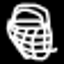
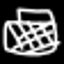
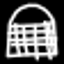
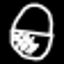
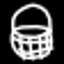
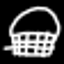
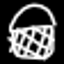
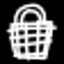


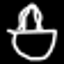
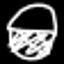
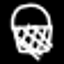
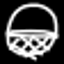
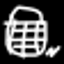
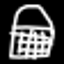
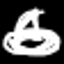
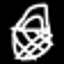
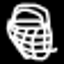
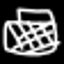
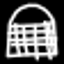
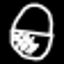
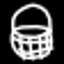
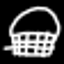
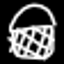
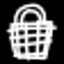

worst



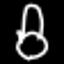
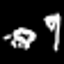
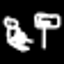
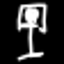
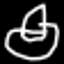
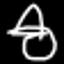
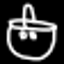
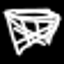
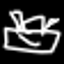
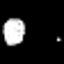
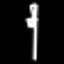
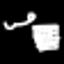
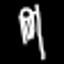
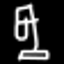
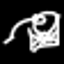
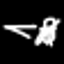


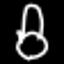
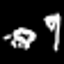
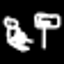
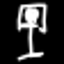
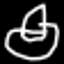
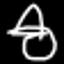
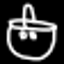
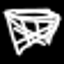
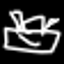
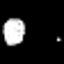
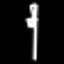
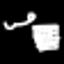
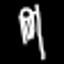
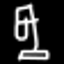
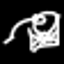
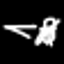


 anvil
best



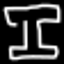
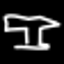
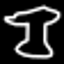
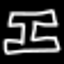
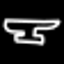
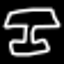
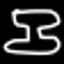
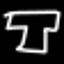
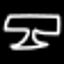
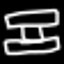
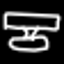
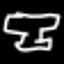
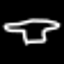
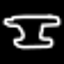
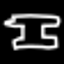
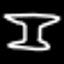


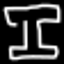
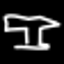
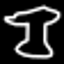
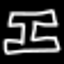
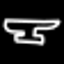
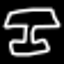
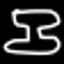
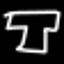
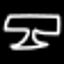
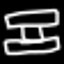
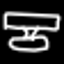
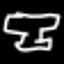
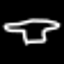
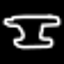
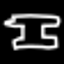
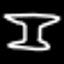

worst



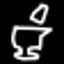
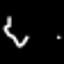
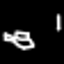
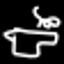
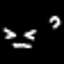
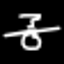
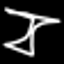
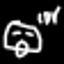
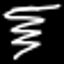
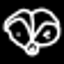
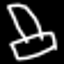
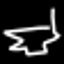
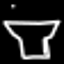
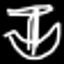
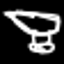
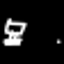


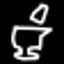
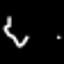
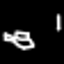
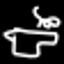
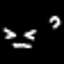
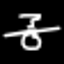
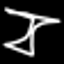
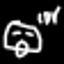
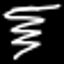
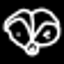
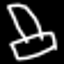
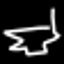
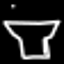
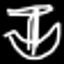
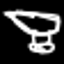
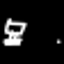


 tree
best



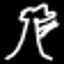
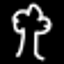
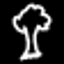
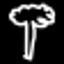
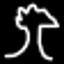
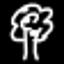
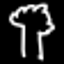
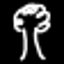
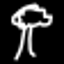
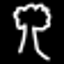
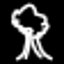
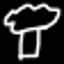
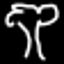
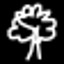
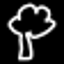
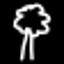


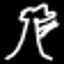
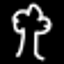
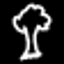
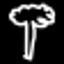
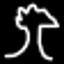
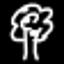
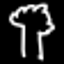
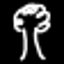
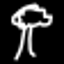
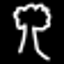
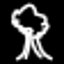
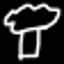
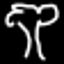
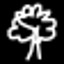
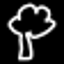
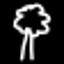

worst



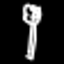
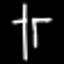
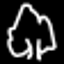
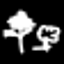
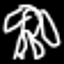
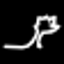
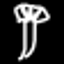
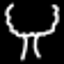
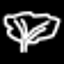
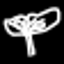
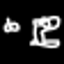
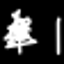
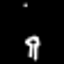
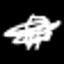
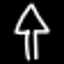
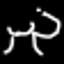


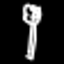
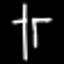
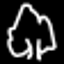
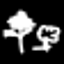
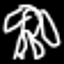
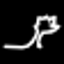
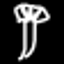
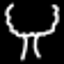
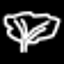
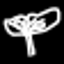
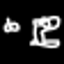
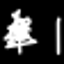
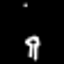
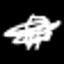
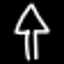
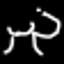


 bed
best



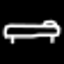
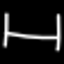
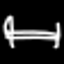
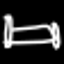
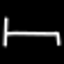
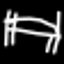
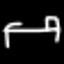
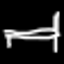
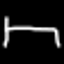
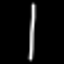
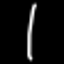
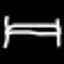
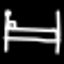
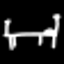
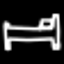
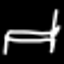


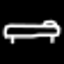
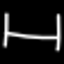
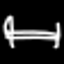
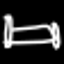
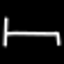
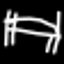
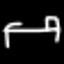
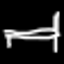
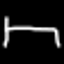
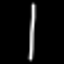
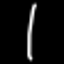
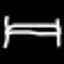
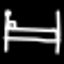
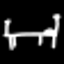
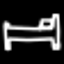
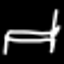

worst



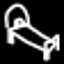
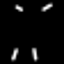
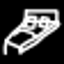
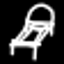
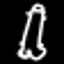
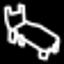
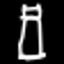
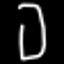
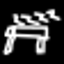
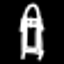
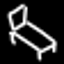
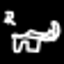
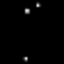
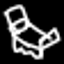
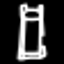
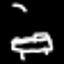


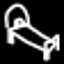
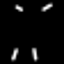
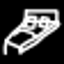
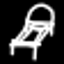
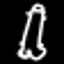
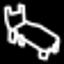
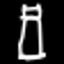
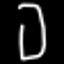
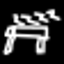
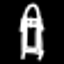
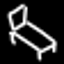
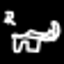
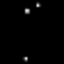
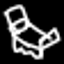
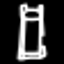
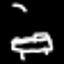


 airplane
best



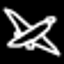
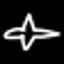
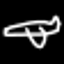
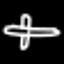
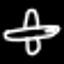
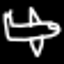
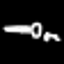
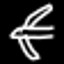
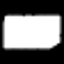
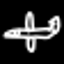
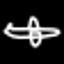
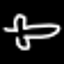
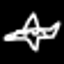
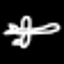
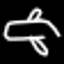
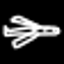


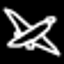
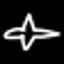
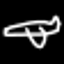
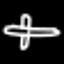
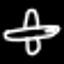
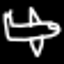
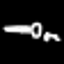
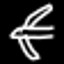
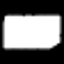
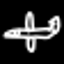
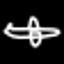
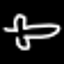
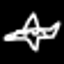
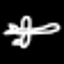
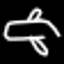
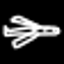

worst



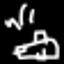
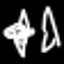
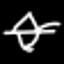
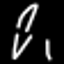
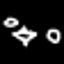
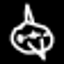
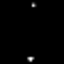
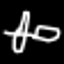
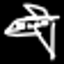
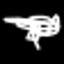
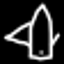
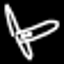
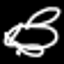
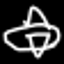
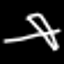
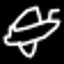


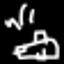
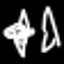
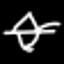
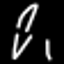
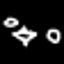
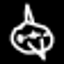
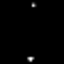
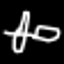
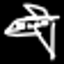
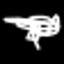
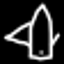
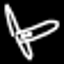
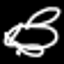
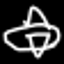
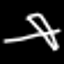
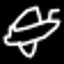


 apple
best



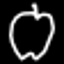
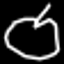
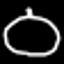
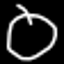
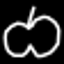
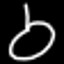
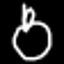
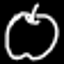
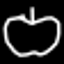
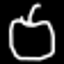
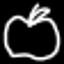
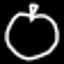
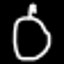
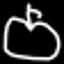
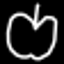
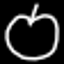


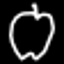
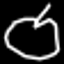
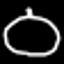
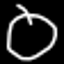
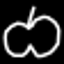
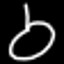
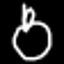
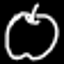
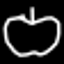
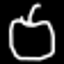
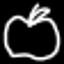
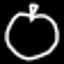
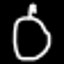
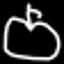
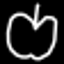
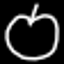

worst



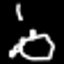
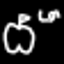
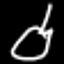
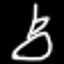
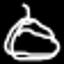
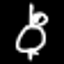
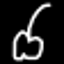
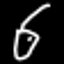
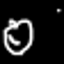
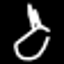
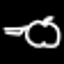
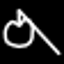
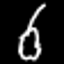
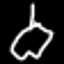
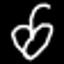
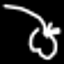


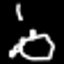
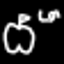
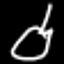
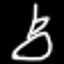
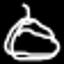
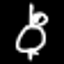
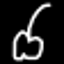
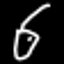
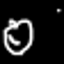
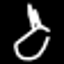
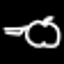
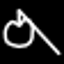
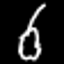
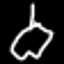
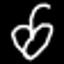
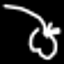


 basketball
best



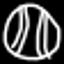
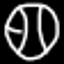
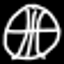
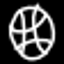
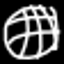
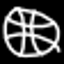
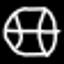
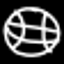
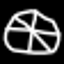
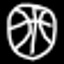
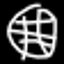
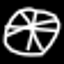
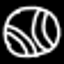
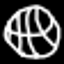
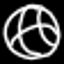
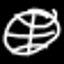


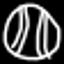
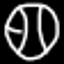
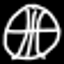
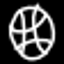
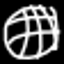
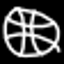
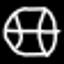
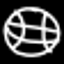
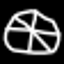
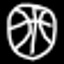
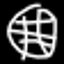
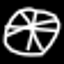
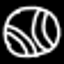
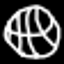
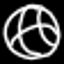
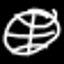

worst



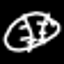
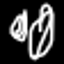
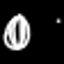
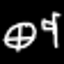
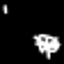
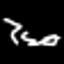
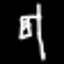
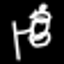
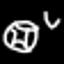
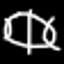
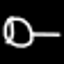
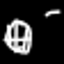
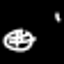
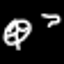
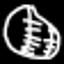
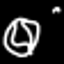


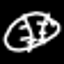
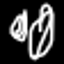
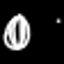
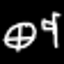
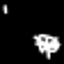
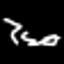
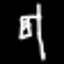
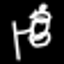
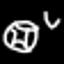
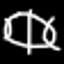
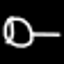
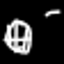
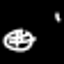
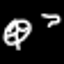
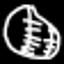
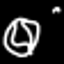


 bicycle
best



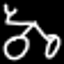
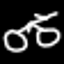
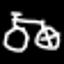
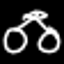
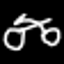
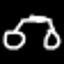
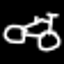
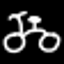
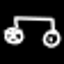
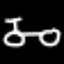
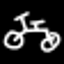
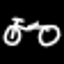
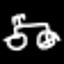
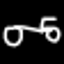
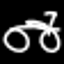
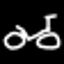


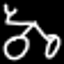
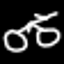
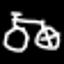
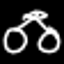
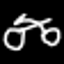
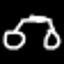
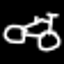
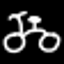
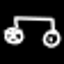
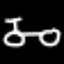
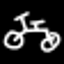
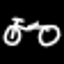
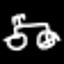
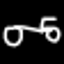
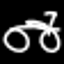
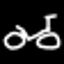

worst



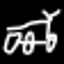
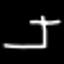
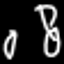
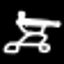
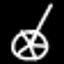
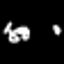
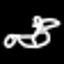
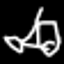
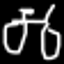
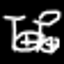
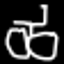
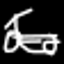
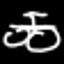
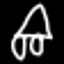
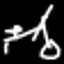
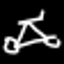


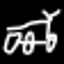
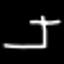
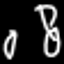
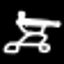
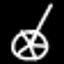
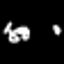
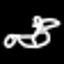
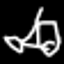
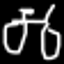
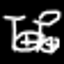
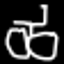
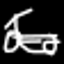
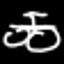
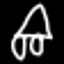
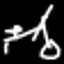
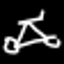

In [17]:
img = 16
img_size = 64
for clid, data in anomalies.items():
    print("\n", class_names[clid])
    
    print("best")
    plot_images(best[clid]['images'], best[clid]['distances'],  max_images=img, img_width=img_size)
    
    print("worst")
    dists = np.array(data['distances'])
    sidxs = np.argsort(-dists)
    plot_images([data['images'][i] for i in sidxs],
                [data['distances'][i] for i in sidxs],
                  max_images=img, img_width=img_size)